In [ ]:
# @title ###### Licensed to the Apache Software Foundation (ASF), Version 2.0 (the "License")

# Licensed to the Apache Software Foundation (ASF) under one
# or more contributor license agreements. See the NOTICE file
# distributed with this work for additional information
# regarding copyright ownership. The ASF licenses this file
# to you under the Apache License, Version 2.0 (the
# "License"); you may not use this file except in compliance
# with the License. You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing,
# software distributed under the License is distributed on an
# "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
# KIND, either express or implied. See the License for the
# specific language governing permissions and limitations
# under the License

# Image Processing using Apache Beam

<table align="left">
  <td>
    <a target="_blank" href="https://colab.sandbox.google.com/github/apache/beam/blob/master/examples/notebooks/beam-ml/image_processing_tensorflow.ipynb"><img src="https://raw.githubusercontent.com/google/or-tools/main/tools/colab_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/apache/beam/blob/master/examples/notebooks/beam-ml/image_processing_tensorflow.ipynb"><img src="https://raw.githubusercontent.com/google/or-tools/main/tools/github_32px.png" />View source on GitHub</a>
  </td>
</table>



Image Processing is a machine learning technique to read, analyze and extract meaningful information from images. It involves multiple steps such as applying various preprocessing functions, getting predictions from a model, storing the predictions in a useful format, etc. Apache Beam is a suitable tool to handle these tasks and build a structured workflow. This notebook demonstrates the use of Apache Beam in image processing and performs the following:
* Import and preprocess the CIFAR-10 dataset
* Train a TensorFlow model to classify images
* Store the model in Google Cloud and create a model handler
* Build a Beam pipeline to:
 1. Create a [PCollection]('https://beam.apache.org/documentation/programming-guide/#pcollections') of input images
 2. Perform preprocessing [transforms]('https://beam.apache.org/documentation/programming-guide/#transforms')
 3. RunInference to get predictions from the previously trained model
 4. Store the results

For more information on using Apache Beam for machine learning, have a look at [AI/ML Pipelines using Beam]('https://beam.apache.org/documentation/ml/overview/').

## Installing Apache Beam

In [ ]:
!pip install apache_beam --quiet
!pip install apache-beam[interactive] --quiet

## Importing necessary libraries
Here is a brief overview of the uses of each library imported:
* **NumPy**: Multidimensional numpy arrays are used to store images, and the library also allows performing various operations on them.
* **Matplotlib**: Displays images stored in numpy array format.
* **TensorFlow**: Trains a machine learning model.
* **TFModelHandlerNumpy**: Defines the configuration used to load/use the model that we train. We use `TFModelHandlerNumpy` because the model was trained with TensorFlow and takes numpy arrays as input.
* **RunInference**:  Loads the model and obtains predictions as part of the Apache Beam pipeline. For more information, see [docs on prediction and inference](https://beam.apache.org/documentation/ml/inference-overview/).
* **Apache Beam**: Builds a pipeline for Image Processing.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from apache_beam.ml.inference.tensorflow_inference import TFModelHandlerNumpy
from apache_beam.ml.inference.base import RunInference
import apache_beam as beam

## CIFAR-10 Dataset
CIFAR-10 is a popular dataset used for multiclass object classification.
It has 60,000 images of the following 10 categories:

* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

The dataset can be directly imported from the TensorFlow library.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [ ]:
x_test.shape

(10000, 32, 32, 3)

The labels in y_train and y_test are numeric, with each number representing a class. The labels list defined below contains the various classes, and their positions in the list represent the corresponding number used to refer to them.

In [ ]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse','Ship', 'Truck']

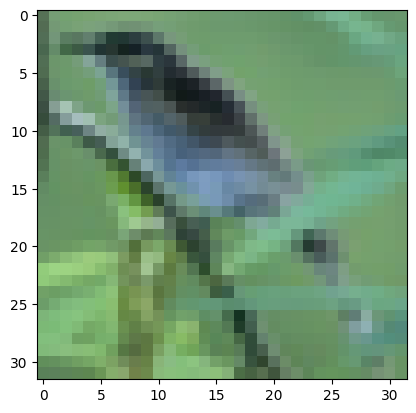

In [ ]:
plt.imshow(x_train[800])

In [ ]:
x_train[0].shape

(32, 32, 3)

(32, 32, 3) represents an image of size 32x32 in the RGB scale

### Preprocessing

**Standardization** is the process of transforming the pixel values of an image to have zero mean and unit variance. This brings the pixel values to a similar scale and makes them easier to work with.

In [ ]:
x_train = x_train/255.0

**Normalization** is the process of scaling the pixel values to a specified range, typically between 0 and 1. This improves the consistency of images.

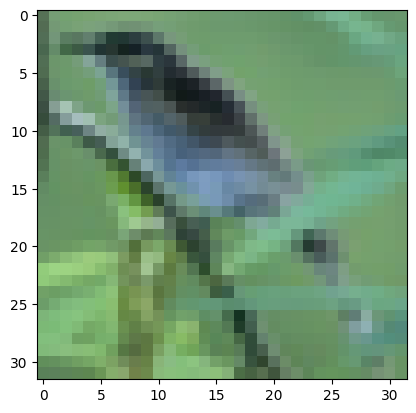

In [ ]:
x_train = (x_train - np.min(x_train)) / (np.max(x_train) - np.min(x_train))
plt.imshow(x_train[800])

**Grayscale Conversion** refers to the conversion of a colored image in RGB scale into a grayscale image. It represents the pixel intensities without considering colors, which makes calculations easier.

In [ ]:
grayscale = []
for i in x_train:
  grayImage = 0.07 * i[:,:,2] + 0.72 * i[:,:,1] + 0.21 * i[:,:,0]
  grayscale.append(grayImage)
x_train_gray = np.asarray(grayscale)

## Defining DoFns for Image Preprocessing

[DoFn](https://beam.apache.org/releases/typedoc/current/interfaces/transforms_pardo.DoFn) stands for "Do Function". In Apache Beam, it is a set of operations that can be applied to individual elements of a PCollection (a collection of data). It is similar to a function in Python, except that it is used in Beam Pipelines to apply various transformations. DoFns can be used in various Apache Beam transforms, such as ParDo, Map, Filter, and FlatMap.

In [ ]:
class StandardizeImage(beam.DoFn):
  def process(self, element: np.ndarray):
    element = element/255.0
    return [element]

In [ ]:
class NormalizeImage(beam.DoFn):
  def process(self, element: np.ndarray):
    element = (element-element.min())/(element.max()-element.min())
    return [element]

In [ ]:
class GrayscaleImage(beam.DoFn):
  def process(self, element: np.ndarray):
    element = 0.07 * element[:,:,2] + 0.72 * element[:,:,1] + 0.21 * element[:,:,0]
    return [element]

## Training a Convolutional Neural Network

A Convolutional Neural Network (CNN) is one of the most popular model types for image processing. Here is a brief description of the convolutional layers used in the model.
* **Reshape**: Changes the shape of the input data to the desired size.
The CIFAR-10 images are of 32x32 pixels in grayscale. We will train our model using these images and thus, all images fed into the model need to be reshaped to the required size, that is (32,32,1).
* **Conv2D**: Applies a set of filters to extract features from the input image, producing a feature map as the output.
This layer is used as it is an essential component of a CNN, and does the major task of finding patterns in images.
* **MaxPooling2D**: Reduces the spatial dimensions of the input while retaining the most prominent features.
We use this layer to downsample the images and preserve only the important features.
* **Flatten**: Flattens the input data or feature maps into a 1-dimensional vector.
The input images are 2-dimensional. However in the end we require our results in a 1-D array. Flatten layer is used for this.
* **Dense**: Connects every neuron in the current layer to every neuron in the subsequent layer.
The CIFAR-10 dataset contains images belonging to 10 different classes. This is why the last dense layer gives 10 outputs, where each output corresponds to the probability of an image belonging to one of the 10 classes.

In [ ]:
def create_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Reshape((32,32,1),input_shape=x_train_gray.shape[1:]),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10)
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          3

The input shape is changed to (32,32,1) as our input images are of 32 x 32 pixels and 1 represents grayscale. In the final dense layer, there are 10 outputs as there are 10 possible classes in the CIFAR-10 dataset.

## Fitting the model

In [ ]:
model.fit(x_train_gray, y_train, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 87s 55ms/step - loss: 1.6511 - accuracy: 0.4054
Epoch 2/10
1563/1563 [==============================] - 84s 54ms/step - loss: 1.2737 - accuracy: 0.5540
Epoch 3/10
1563/1563 [==============================] - 80s 51ms/step - loss: 1.1204 - accuracy: 0.6095
Epoch 4/10
1563/1563 [==============================] - 79s 51ms/step - loss: 1.0184 - accuracy: 0.6461
Epoch 5/10
1563/1563 [==============================] - 80s 51ms/step - loss: 0.9430 - accuracy: 0.6724
Epoch 6/10
1563/1563 [==============================] - 81s 52ms/step - loss: 0.8810 - accuracy: 0.6946
Epoch 7/10
1563/1563 [==============================] - 80s 51ms/step - loss: 0.8299 - accuracy: 0.7135
Epoch 8/10
1563/1563 [==============================] - 80s 51ms/step - loss: 0.7904 - accuracy: 0.7248
Epoch 9/10
1563/1563 [==============================] - 80s 51ms/step - loss: 0.7504 - accuracy: 0.7385
Epoch 10/10
1563/1563 [==============================] - 84s 54m

## Authenticating from Google Cloud

We need to store our trained model in Google Cloud. For running inferences, we will load our model from cloud into the notebook using a Model Handler.

In [ ]:
from google.colab import auth
auth.authenticate_user()

Saving the trained model in a Google Cloud Storage bucket

In [ ]:
save_model_dir = '' # Add the link to you GCS bucket here
model.save(save_model_dir)

A model handler is used to save, load and manage trained ML models. Here we used TFModelHandlerNumpy as our input images are in the form of numpy arrays.

In [ ]:
model_handler = TFModelHandlerNumpy(save_model_dir)

### Saving predictions
RunInference returns the predictions for each class. In the below DoFn, the maximum predicion is selected (which refers to the class the input image most probably belongs to) and is stored in a list of predictions.

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
predictions = []
class SavePredictions(beam.DoFn):
  def process(self, element, *args, **kwargs):
    list_of_predictions = element.inference.tolist()
    highest_prediction = max(list_of_predictions)
    ans = labels[list_of_predictions.index(highest_prediction)]
    predictions.append(ans)

## Building a Beam Pipeline

A Pipeline represents the workflow of a series of computations. Here we are performing the following tasks in our pipeline:
* Creating a PCollection of the data on which we need to run inference
* Appying the Image Preprocessing DoFns we defined earlier <br>
 These include:
 1. Standardization
 2. Normalization
 3. Converting to grayscale
* Running Inference by using the trained model stored in Google Cloud.
* Displaying the output of the model

In [ ]:
with beam.Pipeline() as p:
    _ = (p | beam.Create(x_test)
           | beam.ParDo(StandardizeImage())
           | beam.ParDo(NormalizeImage())
           | beam.ParDo(GrayscaleImage())
           | RunInference(model_handler)
           | beam.ParDo(SavePredictions())
        )

So we got our predictions! Let us verify one of them.

In [ ]:
index = 5000
#You can change this index value to see and verify any image
predictions[index]

'Horse'

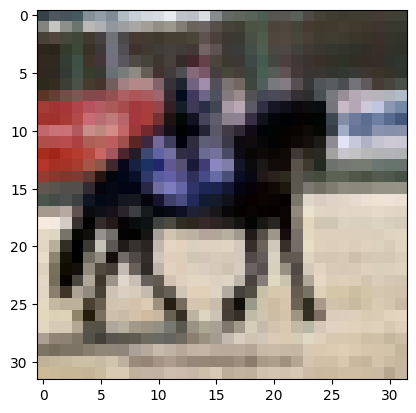

In [ ]:
plt.imshow(x_test[index])

In [ ]:
labels[y_test[index][0]]

'Horse'

Let us make a dictionary to see how many predictions belong to each class

In [ ]:
aggregate_results = dict()
for i in range(len(predictions)):
  if predictions[i] in aggregate_results:
    aggregate_results[predictions[i]] += 1
  else:
    aggregate_results[predictions[i]] = 1

In [ ]:
aggregate_results

{'Dog': 641,
 'Automobile': 3387,
 'Deer': 793,
 'Horse': 1030,
 'Truck': 392,
 'Frog': 290,
 'Airplane': 179,
 'Cat': 3175,
 'Bird': 91,
 'Ship': 22}